# NextPNR Himbaechel Parameter Sweep

This notebook runs the nextpnr-himbaechel tool with different values of connectivity factor and congestion aware factor ranging from 0.1 to 2.0. It automates the parameter sweep to analyze the impact of these factors on placement and routing performance.

The notebook is based on the Fish shell script that runs FABulous FPGA tools and nextpnr-himbaechel for place and route optimization.

## 1. Import Required Libraries

Import necessary Python modules for running shell commands, managing files, and handling results.

In [1]:
import subprocess
import os
import sys
from pathlib import Path
import itertools
import time
import json
from datetime import datetime
import pandas as pd
import numpy as np
from loguru import logger
import concurrent.futures

# Configure loguru logger - output only to stdout
logger.remove()  # Remove default handler
logger.add(sys.stdout, format="{time} | {level} | {message}", level="INFO")

logger.info("Imported required libraries for nextpnr parameter sweep")

2025-06-16T21:38:32.387774+0100 | INFO | Imported required libraries for nextpnr parameter sweep


## 2. Define Parameter Ranges and Configuration

Set up parameter ranges for connectivity factor and congestion-aware factor, and define file paths based on the original script.

In [2]:
# Define parameter ranges
CONNECTIVITY_FACTORS = np.arange(0.0, 2.1, 0.2)  # 0.1 to 2.0 with step 0.1
CONGESTION_FACTORS = np.arange(0.0, 2.1, 0.2)    # 0.1 to 2.0 with step 0.1

# Configuration constants from the original script
MY_FAB_ROOT = Path("/home/kelvin/FABulous_fork")
SOURCE_HDL = MY_FAB_ROOT / "benchmarks/userbench/loop_array_inner/loop_array_inner.sv"
FAB_PROJ_DIR = Path("/home/kelvin/FABulous_fork/myProject")
os.environ["FAB_PROJ_DIR"] = str(FAB_PROJ_DIR)
os.environ["PATH"] = f"/home/kelvin/nextpnr/build/bba:{os.environ["PATH"]}"
os.environ["PATH"] = f"/home/kelvin/nextpnr/build:{os.environ["PATH"]}"

# File paths
CHIPDB_PATH = FAB_PROJ_DIR / ".FABulous/hycube.bit"
JSON_INPUT = FAB_PROJ_DIR / "user_design/synth_test.json"
CONSTRAIN_PAIR = FAB_PROJ_DIR / ".FABulous/hycube_constrain_pair.inc"
FDC_PATH = FAB_PROJ_DIR / "user_design/test.fdc"

# Output directory for results
OUTPUT_DIR = Path("/home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results")
OUTPUT_DIR.mkdir(exist_ok=True)

# Fixed parameters
BETA_VALUE = 0.9
PLACE_TRIALS = 1
ROUTER_TIMEOUT = 20000

logger.info(f"Parameter ranges defined: {len(CONNECTIVITY_FACTORS)} connectivity × {len(CONGESTION_FACTORS)} congestion = {len(CONNECTIVITY_FACTORS) * len(CONGESTION_FACTORS)} total combinations")
logger.info(f"Output directory: {OUTPUT_DIR}")

2025-06-16T21:38:32.391981+0100 | INFO | Parameter ranges defined: 11 connectivity × 11 congestion = 121 total combinations
2025-06-16T21:38:32.392259+0100 | INFO | Output directory: /home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results


## 3. Build nextpnr-himbaechel Command Function

Define functions to run FABulous preprocessing and nextpnr-himbaechel with given parameter values.

In [ ]:
def run_fabulous_preprocessing() -> bool:
    """
    Run FABulous preprocessing commands to generate necessary files.
    
    Returns
    -------
    bool
        True if successful, False otherwise
    """
        
    # Run FABulous command
    fabulous_cmd = [
        "FABulous", "--debug", str(FAB_PROJ_DIR), "-p",
        "load_fabric; gen_bitStream_spec; gen_cells_and_techmaps; "
        f"gen_chipdb -routing_graph {FAB_PROJ_DIR}/.FABulous/routing_graph.dot -filter 5,1 5,2 5,3 5,4; "
        f"synthesis_script {SOURCE_HDL} -tcl {FAB_PROJ_DIR}/.FABulous/arch_synth.tcl;"
    ]
    
    print("Running FABulous preprocessing...")
    print(f"Command: {' '.join(fabulous_cmd)}")
    
    # Set environment for subprocess
    env = os.environ.copy()
    result = subprocess.run(fabulous_cmd, capture_output=True, text=True, timeout=300, env=env)
    
    if result.returncode != 0:
        print(f"FABulous preprocessing failed with return code: {result.returncode}")
        print(f"STDOUT: {result.stdout}")
        print(f"STDERR: {result.stderr}")
        
        return False
    
    print("FABulous preprocessing completed successfully")
    return True
        
    
def run_nextpnr_himbaechel(connectivityFactor: float, congestionFactor: float) -> dict:
    """
    Run nextpnr-himbaechel with specified parameters.
    
    Parameters
    ----------
    connectivityFactor : float
        Placer heap architecture connectivity factor
    congestionFactor : float
        Placer heap congestion aware factor
    
    Returns
    -------
    dict
        Dictionary containing run results and metadata
    """
    # Generate unique output filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    conn_str = f"{connectivityFactor:.1f}".replace(".", "p")
    cong_str = f"{congestionFactor:.1f}".replace(".", "p")
    
    output_json = OUTPUT_DIR / f"router_test_conn{conn_str}_cong{cong_str}.json"
    output_fasm = OUTPUT_DIR / f"router_test_conn{conn_str}_cong{cong_str}.fasm"
    
    # Build nextpnr command
    nextpnr_cmd = [
        "nextpnr-himbaechel",
        "--chipdb", str(CHIPDB_PATH),
        "--device", "FABulous",
        "--json", str(JSON_INPUT),
        "--write", str(output_json),
        "-o", f"constrain-pair={CONSTRAIN_PAIR}",
        # "-o", f"fasm={output_fasm}",
        "-o", f"fdc={FDC_PATH}",
        "--placer-heap-seed-placement-strategy", "graph_grid",
        "--placer-heap-beta", str(BETA_VALUE),
        "--placer-heap-arch-connectivity-factor", str(connectivityFactor),
        "--placer-heap-congestion-aware-factor", str(congestionFactor),
        "-o", f"placeTrial={PLACE_TRIALS}",
        "--router1-timeout", str(ROUTER_TIMEOUT)
    ]
    print(" ".join(nextpnr_cmd))
    start_time = time.time()
    
    try:
        logger.info(f"Running nextpnr with connectivity={connectivityFactor:.1f}, congestion={congestionFactor:.1f}")
        
        # Set environment for subprocess
        env = os.environ.copy()
        result = subprocess.run(nextpnr_cmd, capture_output=True, text=True, timeout=600, env=env)
        end_time = time.time()
        runtime = end_time - start_time
        # Parse output for metrics (simplified - you may want to add more sophisticated parsing)
        success = result.returncode == 0
        
        return {
            "connectivityFactor": connectivityFactor,
            "congestionFactor": congestionFactor,
            "success": success,
            "runtime": runtime,
            "returnCode": result.returncode,
            "stdout": result.stdout,
            "stderr": result.stderr,
            "outputJson": str(output_json) if success else None,
            "outputFasm": str(output_fasm) if success else None,
            "timestamp": timestamp
        }
        
    except subprocess.TimeoutExpired:
        end_time = time.time()
        runtime = end_time - start_time
        logger.warning(f"nextpnr timed out for connectivity={connectivityFactor:.1f}, congestion={congestionFactor:.1f}")
        
        return {
            "connectivityFactor": connectivityFactor,
            "congestionFactor": congestionFactor,
            "success": False,
            "runtime": runtime,
            "returnCode": -1,
            "stdout": "",
            "stderr": "Timeout",
            "outputJson": None,
            "outputFasm": None,
            "timestamp": timestamp
        }
    except Exception as e:
        end_time = time.time()
        runtime = end_time - start_time
        print(f"Error running nextpnr: {e}")
        
        return {
            "connectivityFactor": connectivityFactor,
            "congestionFactor": congestionFactor,
            "success": False,
            "runtime": runtime,
            "returnCode": -2,
            "stdout": "",
            "stderr": str(e),
            "outputJson": None,
            "outputFasm": None,
            "timestamp": timestamp
        }

logger.info("Helper functions defined successfully")

2025-06-16T21:38:32.398709+0100 | INFO | Helper functions defined successfully


## 4. Run nextpnr-himbaechel with Parameter Grid

Execute the parameter sweep by running nextpnr-himbaechel for all combinations of connectivity and congestion-aware factors.

In [4]:
# First, run FABulous preprocessing (only needs to be done once)
logger.info("Starting FABulous preprocessing...")
preprocessing_success = run_fabulous_preprocessing()

if not preprocessing_success:
    logger.error("FABulous preprocessing failed. Cannot continue with parameter sweep.")
    raise RuntimeError("FABulous preprocessing failed")

logger.info("FABulous preprocessing completed successfully. Ready for parameter sweep.")

2025-06-16T21:38:32.402132+0100 | INFO | Starting FABulous preprocessing...
Running FABulous preprocessing...
Command: FABulous --debug /home/kelvin/FABulous_fork/myProject -p load_fabric; gen_bitStream_spec; gen_cells_and_techmaps; gen_chipdb -routing_graph /home/kelvin/FABulous_fork/myProject/.FABulous/routing_graph.dot -filter 5,1 5,2 5,3 5,4; synthesis_script /home/kelvin/FABulous_fork/benchmarks/userbench/loop_array_inner/loop_array_inner.sv -tcl /home/kelvin/FABulous_fork/myProject/.FABulous/arch_synth.tcl;
FABulous preprocessing completed successfully
2025-06-16T21:38:34.146815+0100 | INFO | FABulous preprocessing completed successfully. Ready for parameter sweep.


In [5]:
# Run parameter sweep in parallel
results = []
totalCombinations = len(CONNECTIVITY_FACTORS) * len(CONGESTION_FACTORS)
currentRun = 0

logger.info(f"Starting parameter sweep with {totalCombinations} combinations")

grid = list(itertools.product(CONNECTIVITY_FACTORS, CONGESTION_FACTORS))
# grid = [(0, 0), (0, 1), (1, 0), (1, 1)]

def run_and_log(args: tuple) -> dict:
    connectivityFactor, congestionFactor = args
    logger.info(f"Run: connectivity={connectivityFactor:.1f}, congestion={congestionFactor:.1f}")
    result = run_nextpnr_himbaechel(connectivityFactor, congestionFactor)
    if result["success"]:
        logger.info(f"✓ Run completed successfully in {result['runtime']:.2f}s")
    else:
        logger.warning(f"✗ Run failed with return code {result['returnCode']} in {result['runtime']:.2f}s")
    return result

maxWorkers = min(28, os.cpu_count() or 2)  # Limit concurrency to avoid overload

with concurrent.futures.ThreadPoolExecutor(max_workers=maxWorkers) as executor:
    futures = [executor.submit(run_and_log, args) for args in grid]
    for future in concurrent.futures.as_completed(futures):
        results.append(future.result())

logger.info(f"Parameter sweep completed! Processed {len(results)} combinations")

2025-06-16T21:38:34.151267+0100 | INFO | Starting parameter sweep with 121 combinations
2025-06-16T21:38:34.152159+0100 | INFO | Run: connectivity=0.0, congestion=0.0
nextpnr-himbaechel --chipdb /home/kelvin/FABulous_fork/myProject/.FABulous/hycube.bit --device FABulous --json /home/kelvin/FABulous_fork/myProject/user_design/synth_test.json --write /home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results/router_test_conn0p0_cong0p0_20250616_213834.json -o constrain-pair=/home/kelvin/FABulous_fork/myProject/.FABulous/hycube_constrain_pair.inc -o fasm=/home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results/router_test_conn0p0_cong0p0_20250616_213834.fasm -o fdc=/home/kelvin/FABulous_fork/myProject/user_design/test.fdc --placer-heap-seed-placement-strategy graph_grid --placer-heap-beta 0.9 --placer-heap-arch-connectivity-factor 0.0 --placer-heap-congestion-aware-factor 0.0 -o placeTrial=1 --router1-timeout 20000
2025-06-16T21:38:34.152581+0100 | INFO | Run: connectivity=0

## 5. Collect and Display Results

Aggregate the results into a pandas DataFrame and analyze the outcomes.

In [6]:
# Create DataFrame from results
df = pd.DataFrame(results)

# Display basic statistics
logger.info("Parameter sweep results summary:")
logger.info(f"Total runs: {len(df)}")
logger.info(f"Successful runs: {df['success'].sum()}")
logger.info(f"Failed runs: {(~df['success']).sum()}")
logger.info(f"Average runtime: {df['runtime'].mean():.2f}s")

# Display the results DataFrame
print("\\n=== Parameter Sweep Results ===")
print(df[['connectivityFactor', 'congestionFactor', 'success', 'runtime', 'returnCode']].head(20))

# Summary statistics
print("\\n=== Summary Statistics ===")
print(f"Success rate: {df['success'].mean()*100:.1f}%")
print(f"Average runtime for successful runs: {df[df['success']]['runtime'].mean():.2f}s")
print(f"Min runtime: {df['runtime'].min():.2f}s")
print(f"Max runtime: {df['runtime'].max():.2f}s")

2025-06-16T21:42:02.684318+0100 | INFO | Parameter sweep results summary:
2025-06-16T21:42:02.684649+0100 | INFO | Total runs: 121
2025-06-16T21:42:02.685141+0100 | INFO | Successful runs: 30
2025-06-16T21:42:02.685495+0100 | INFO | Failed runs: 91
2025-06-16T21:42:02.686090+0100 | INFO | Average runtime: 25.22s
\n=== Parameter Sweep Results ===
    connectivityFactor  congestionFactor  success    runtime  returnCode
0                  0.0               0.0     True   1.949665           0
1                  0.0               1.0     True   5.123008           0
2                  0.0               0.2     True   6.484329           0
3                  0.0               0.6    False  12.124696         255
4                  0.0               0.4    False  12.919565         255
5                  0.2               0.8     True  13.045235           0
6                  0.0               1.4    False  13.363203         255
7                  0.0               1.2    False  13.846427        

In [7]:
# Save results to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_file = OUTPUT_DIR / f"parameter_sweep_results_{timestamp}.csv"
df.to_csv(results_file, index=False)
logger.info(f"Results saved to: {results_file}")

# Save detailed results to JSON
json_file = OUTPUT_DIR / f"parameter_sweep_detailed_{timestamp}.json"
with open(json_file, "w") as f:
    json.dump(results, f, indent=2)
logger.info(f"Detailed results saved to: {json_file}")

# Create pivot tables for analysis
if df['success'].any():  # Only if we have successful runs
    successful_df = df[df['success']]
    
    # Runtime analysis
    runtime_pivot = successful_df.pivot_table(
        values="runtime", 
        index="connectivityFactor", 
        columns="congestionFactor", 
        aggfunc="mean"
    )
    
    print("\n=== Runtime Pivot Table (seconds) ===")
    print("Rows: Connectivity Factor, Columns: Congestion Factor")
    print(runtime_pivot.round(2))
    
    # Success rate analysis
    success_pivot = df.pivot_table(
        values="success", 
        index="connectivityFactor", 
        columns="congestionFactor", 
        aggfunc="mean"
    )
    
    print("\n=== Success Rate Pivot Table ===")
    print("Rows: Connectivity Factor, Columns: Congestion Factor")
    print(success_pivot.round(3))
    
else:
    logger.warning("No successful runs found. Cannot create analysis tables.")

print("\n=== Analysis Complete ===")
print(f"Results saved to: {OUTPUT_DIR}")

2025-06-16T21:42:02.711320+0100 | INFO | Results saved to: /home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results/parameter_sweep_results_20250616_214202.csv


2025-06-16T21:42:02.716940+0100 | INFO | Detailed results saved to: /home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results/parameter_sweep_detailed_20250616_214202.json

=== Runtime Pivot Table (seconds) ===
Rows: Connectivity Factor, Columns: Congestion Factor
congestionFactor      0.0    0.2    0.4    0.6    0.8    1.0    1.2    1.4  \
connectivityFactor                                                           
0.0                  1.95   6.48    NaN    NaN    NaN   5.12    NaN    NaN   
0.2                   NaN    NaN    NaN    NaN  13.05    NaN    NaN    NaN   
0.4                 11.21  13.69    NaN    NaN    NaN  11.03    NaN    NaN   
0.8                   NaN  12.53    NaN    NaN    NaN    NaN  29.67    NaN   
1.0                 20.21  26.85    NaN  27.31    NaN    NaN    NaN    NaN   
1.2                 22.83  29.86  30.17    NaN  25.00    NaN    NaN    NaN   
1.4                 23.75  31.16  31.22    NaN    NaN    NaN    NaN    NaN   
1.6                   NaN 

## Optional: Visualization and Further Analysis

Add visualization capabilities if matplotlib/seaborn are available, and provide options for further analysis.

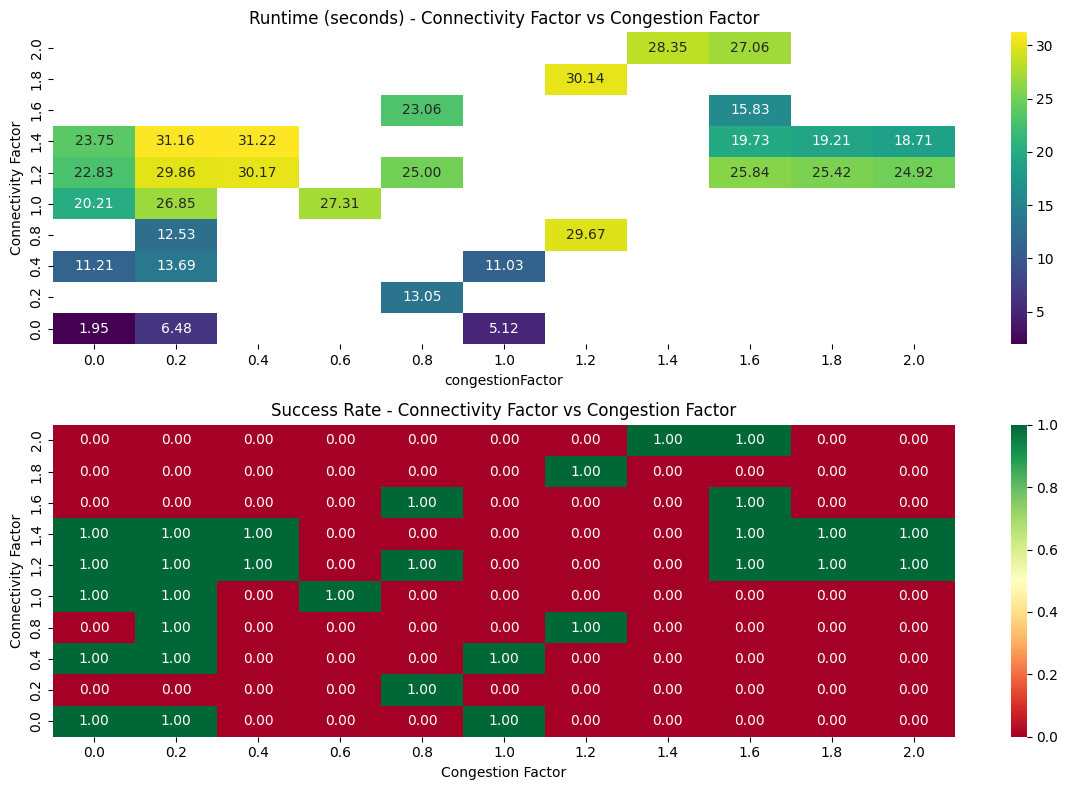

2025-06-16T22:02:20.793552+0100 | INFO | Heatmap saved to: /home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results/parameter_sweep_heatmap_20250616_214202.png

PARAMETER SWEEP COMPLETE
Total parameter combinations tested: 121
Successful runs: 30
Results directory: /home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results

=== Environment Variables ===
You can customize the following settings by setting environment variables:
- MY_FAB_ROOT: FABulous root directory (default: /home/kelvin/FABulous_fork)
- FAB_PROJ_DIR: Project directory name (default: myProject)
- SOURCE_HDL: Source HDL file path
- OUTPUT_DIR: Results output directory
- BETA_VALUE: Placer heap beta value (default: 0.9)
- PLACE_TRIALS: Number of place trials (default: 1)
- ROUTER_TIMEOUT: Router timeout in seconds (default: 200000)

PARAMETER SWEEP COMPLETE
Total parameter combinations tested: 121
Successful runs: 30
Results directory: /home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results

=== En

In [13]:
# Optional: Create visualizations if matplotlib is available
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    if df['success'].any():
        successful_df = df[df['success']]

        # Round axis values to 2 decimal places to avoid floating point artifacts
        successful_df = successful_df.copy()
        successful_df["connectivityFactor"] = successful_df["connectivityFactor"].round(2)
        successful_df["congestionFactor"] = successful_df["congestionFactor"].round(2)
        df["connectivityFactor"] = df["connectivityFactor"].round(2)
        df["congestionFactor"] = df["congestionFactor"].round(2)

        # Ensure both axes are sorted - congestion ascending (left to right), connectivity descending (bottom to top)
        connectivityOrder = sorted(successful_df["connectivityFactor"].unique(), reverse=True)  # Reverse to put 0.0 at bottom
        congestionOrder = sorted(successful_df["congestionFactor"].unique())  # Normal order to put 0.0 at left

        plt.figure(figsize=(12, 8))

        # Runtime heatmap
        plt.subplot(2, 1, 1)
        runtime_pivot = successful_df.pivot_table(
            values="runtime", 
            index="connectivityFactor", 
            columns="congestionFactor", 
            aggfunc="mean"
        ).reindex(index=connectivityOrder, columns=congestionOrder)
        sns.heatmap(runtime_pivot, annot=True, fmt=".2f", cmap="viridis")
        plt.title("Runtime (seconds) - Connectivity Factor vs Congestion Factor")
        plt.ylabel("Connectivity Factor")

        # Success rate heatmap
        plt.subplot(2, 1, 2)
        success_pivot = df.pivot_table(
            values="success", 
            index="connectivityFactor", 
            columns="congestionFactor", 
            aggfunc="mean"
        ).reindex(index=connectivityOrder, columns=congestionOrder)
        sns.heatmap(success_pivot, annot=True, fmt=".2f", cmap="RdYlGn")
        plt.title("Success Rate - Connectivity Factor vs Congestion Factor")
        plt.ylabel("Connectivity Factor")
        plt.xlabel("Congestion Factor")

        plt.tight_layout()

        # Save plot
        plot_file = OUTPUT_DIR / f"parameter_sweep_heatmap_{timestamp}.png"
        plt.savefig(plot_file, dpi=300, bbox_inches="tight")
        plt.show()

        logger.info(f"Heatmap saved to: {plot_file}")

    else:
        logger.warning("No successful runs to visualize")
        
except ImportError:
    logger.info("matplotlib/seaborn not available. Skipping visualization.")
    print("To enable visualizations, install matplotlib and seaborn:")
    print("pip install matplotlib seaborn")

# Final summary
print("\n" + "="*50)
print("PARAMETER SWEEP COMPLETE")
print("="*50)
print(f"Total parameter combinations tested: {len(df)}")
print(f"Successful runs: {df['success'].sum()}")
print(f"Results directory: {OUTPUT_DIR}")
print("="*50)

# Environment variables that can be set:
print("\n=== Environment Variables ===")
print("You can customize the following settings by setting environment variables:")
print("- MY_FAB_ROOT: FABulous root directory (default: /home/kelvin/FABulous_fork)")
print("- FAB_PROJ_DIR: Project directory name (default: myProject)")
print("- SOURCE_HDL: Source HDL file path")
print("- OUTPUT_DIR: Results output directory")
print("- BETA_VALUE: Placer heap beta value (default: 0.9)")
print("- PLACE_TRIALS: Number of place trials (default: 1)")
print("- ROUTER_TIMEOUT: Router timeout in seconds (default: 200000)")
print("="*50)